Name: Sagar Nandeshwar
<br>Student ID: 260920948

## Import Statements

In [1]:
import pandas as pd
import numpy as np
import random
import seaborn
import matplotlib.pyplot as plt

## Uploading Data

In [2]:
meta_data = pd.read_csv('D_ICD_DIAGNOSES.csv.gz', compression='gzip')
ehr = pd.read_csv('MIMIC3_DIAGNOSES_ICD_subset.csv.gz', compression='gzip')

## Mapping Subject ID and ICD Code to index

In [3]:
define_subject = {}
iter_n = 0
for subject in ehr["SUBJECT_ID"]:
    if subject not in define_subject.keys():
        define_subject[subject] = iter_n
        iter_n = iter_n + 1
        
define_icd = {}
iter_n = 0
for icd in ehr["ICD9_CODE"]:
    if icd not in define_icd.keys():
        define_icd[icd] = iter_n
        iter_n = iter_n + 1

## Hyperparameter

In [4]:
alpha = 1
beta = 0.001
K = 5
M = len(define_icd)
D = len(define_subject)
X = len(ehr)

## Initialization with Random topic

In [5]:
def get_topic(ehr):
    topic_data = []
    for index, row in ehr.iterrows():
        record = (row["SUBJECT_ID"], row["ICD9_CODE"])
        topic = np.random.randint(5) 
        topic_data.append([record, topic])
    topic_df = pd.DataFrame(topic_data, columns=["Record", "Topic"])
    return topic_df

## Calculate Gamma

In [6]:
def cal_gamma(n_dk, n_wk, patient, icd_code):
    left = cal_left(n_dk, patient)
    right = cal_right(n_wk, icd_code)
    return np.multiply(left, right)

def cal_left(n_dk, patient):   
    return alpha + n_dk[define_subject[patient]]   

def cal_right(n_wk, icd_code):
    nemo_sum = beta + n_wk[define_icd[icd_code]]
    deno_sum = (beta * M) + np.sum(n_wk, axis=0)    
    return nemo_sum / deno_sum

## Recover Theta and Phi

In [7]:
def cal_phi(n_wk):
    num = beta + n_wk 
    den = (M * beta) + np.sum(n_wk, axis=0)
    return num / den

def cal_theta(n_dk):
    num = alpha + n_dk 
    den = (K * alpha) + np.sum(n_dk, axis=1)
    return num / den[:,None]

## Run 

In [8]:
def sample_topic(p):
    return np.random.multinomial(1,p).argmax()

def update_stats(topic_df, n_dk, n_wk):
    for index, rows in topic_df.iterrows():
        patient = rows["Record"][0]
        icd_code = rows["Record"][1]
        cur_topic = rows["Topic"]
        n_dk[define_subject[patient]][cur_topic] += 1
        n_wk[define_icd[icd_code]][cur_topic] += 1
    return n_dk, n_wk


def update_topic(topic_df, z_id): 
    for index in range(X):
        topic_df.at[index, "Topic"] = sample_topic(z_id[index])
    return topic_df

    
def run(topic_df, n_dk, n_wk):
    for iter_n in range(100):
        # Sampling
        z_id = np.zeros([X, K]) # probability pval values matrix
        for index, rows in topic_df.iterrows():
            patient = rows["Record"][0]
            icd_code = rows["Record"][1]
            cur_topic = rows["Topic"]
            
            # Decrement by -1
            n_dk[define_subject[patient]][cur_topic] -= 1
            n_wk[define_icd[icd_code]][cur_topic] -= 1
            
            # pval probability
            result = cal_gamma(n_dk, n_wk, patient, icd_code)            
            result = result / np.sum(result)
            z_id[index] = result
            
            # Increment by +1
            n_dk[define_subject[patient]][cur_topic] += 1
            n_wk[define_icd[icd_code]][cur_topic] += 1
        topic_df = update_topic(topic_df, z_id)
        
        # Updating
        n_dk, n_wk = update_stats(topic_df, n_dk, n_wk)
        
    # recovring Theta and Phi
    phi = cal_phi(n_wk)
    theta = cal_theta(n_dk)
    return phi, theta

## Main 

In [9]:
n_dk = np.zeros([D, K], dtype = int)
n_wk = np.zeros([M, K], dtype = int)

topic_df = get_topic(ehr)
n_dk, n_wk = update_stats(topic_df, n_dk, n_wk)
phi_r, theta_r = run(topic_df, n_dk, n_wk)

## Question 2

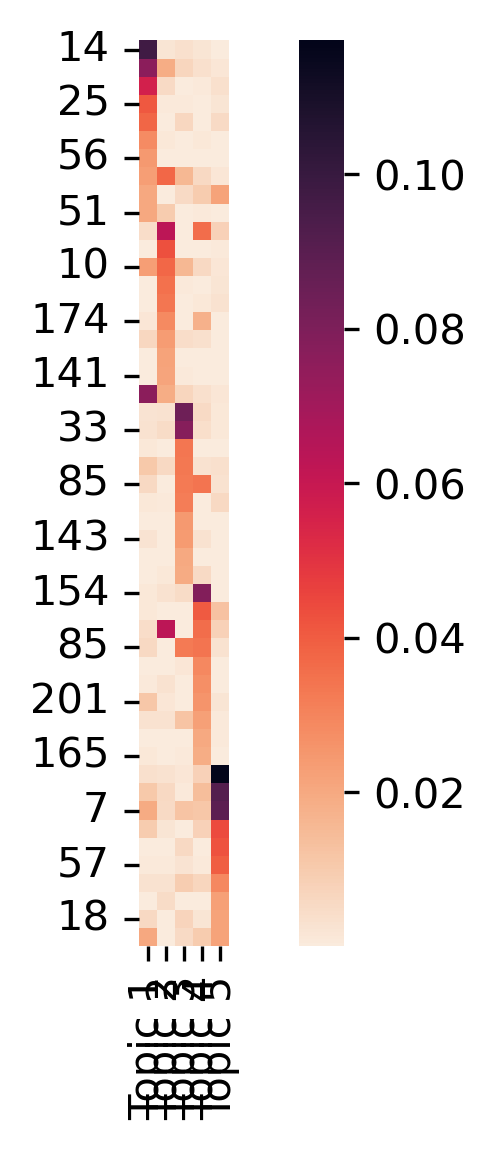

In [10]:
phi_df = pd.DataFrame(phi_r, columns=["Topic 1", "Topic 2", "Topic 3", "Topic 4", "Topic 5"])
top_0_phi = phi_df.nlargest(10, "Topic 1")
top_1_phi = phi_df.nlargest(10, "Topic 2")
top_2_phi = phi_df.nlargest(10, "Topic 3")
top_3_phi = phi_df.nlargest(10, "Topic 4")
top_4_phi = phi_df.nlargest(10, "Topic 5")

top_phi_df = pd.concat([top_0_phi, top_1_phi])
top_phi_df = pd.concat([top_phi_df, top_2_phi])
top_phi_df = pd.concat([top_phi_df, top_3_phi])
top_phi_df = pd.concat([top_phi_df, top_4_phi])

plt.figure(dpi=300)
ax = seaborn.heatmap(top_phi_df, cmap="rocket_r",  square=True)
plt.show()

## Question 3

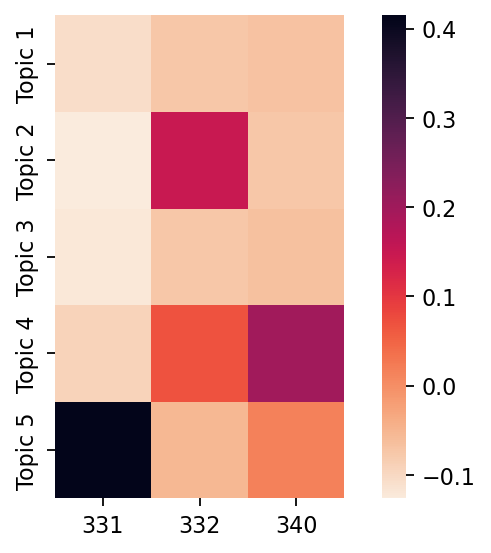

In [11]:
def get_coor():
    cood_id = np.zeros([D, 3], dtype = int)
    for index, row in ehr.iterrows():
        subject = row["SUBJECT_ID"]
        icd = row["ICD9_CODE"]
        if compare(icd, "331"):
            cood_id[define_subject[subject]][0] = 1
        if compare(icd, "332"):
            cood_id[define_subject[subject]][1] = 1
        if compare(icd, "340"):
            cood_id[define_subject[subject]][2] = 1 
    cood_topic_df = pd.DataFrame(cood_id, columns=["331", "332", "340"])
    return cood_topic_df


def compare(icd, num):
    icd = str(icd)
    return icd.startswith(num)


theta_df = pd.DataFrame(theta_r, columns=["T1", "T2", "T3", "T4", "T5"])
cood_topic_df = get_coor()


coor_t1_c1 = theta_df["T1"].corr(cood_topic_df["331"])
coor_t2_c1 = theta_df["T2"].corr(cood_topic_df["331"])
coor_t3_c1 = theta_df["T3"].corr(cood_topic_df["331"])
coor_t4_c1 = theta_df["T4"].corr(cood_topic_df["331"])
coor_t5_c1 = theta_df["T5"].corr(cood_topic_df["331"])

coor_t1_c2 = theta_df["T1"].corr(cood_topic_df["332"])
coor_t2_c2 = theta_df["T2"].corr(cood_topic_df["332"])
coor_t3_c2 = theta_df["T3"].corr(cood_topic_df["332"])
coor_t4_c2 = theta_df["T4"].corr(cood_topic_df["332"])
coor_t5_c2 = theta_df["T5"].corr(cood_topic_df["332"])

coor_t1_c3 = theta_df["T1"].corr(cood_topic_df["340"])
coor_t2_c3 = theta_df["T2"].corr(cood_topic_df["340"])
coor_t3_c3 = theta_df["T3"].corr(cood_topic_df["340"])
coor_t4_c3 = theta_df["T4"].corr(cood_topic_df["340"])
coor_t5_c3 = theta_df["T5"].corr(cood_topic_df["340"])


coor_data = []
coor_data.append([coor_t1_c1, coor_t1_c2, coor_t1_c3])
coor_data.append([coor_t2_c1, coor_t2_c2, coor_t2_c3])
coor_data.append([coor_t3_c1, coor_t3_c2, coor_t3_c3])
coor_data.append([coor_t4_c1, coor_t4_c2, coor_t4_c3])
coor_data.append([coor_t5_c1, coor_t5_c2, coor_t5_c3])


coor_df = pd.DataFrame(coor_data, index=["Topic 1", "Topic 2", "Topic 3", "Topic 4", "Topic 5"], columns=["331", "332", "340"])

plt.figure(dpi=160)
ax = seaborn.heatmap(coor_df, cmap="rocket_r", square=True)
plt.show()

## Question 4

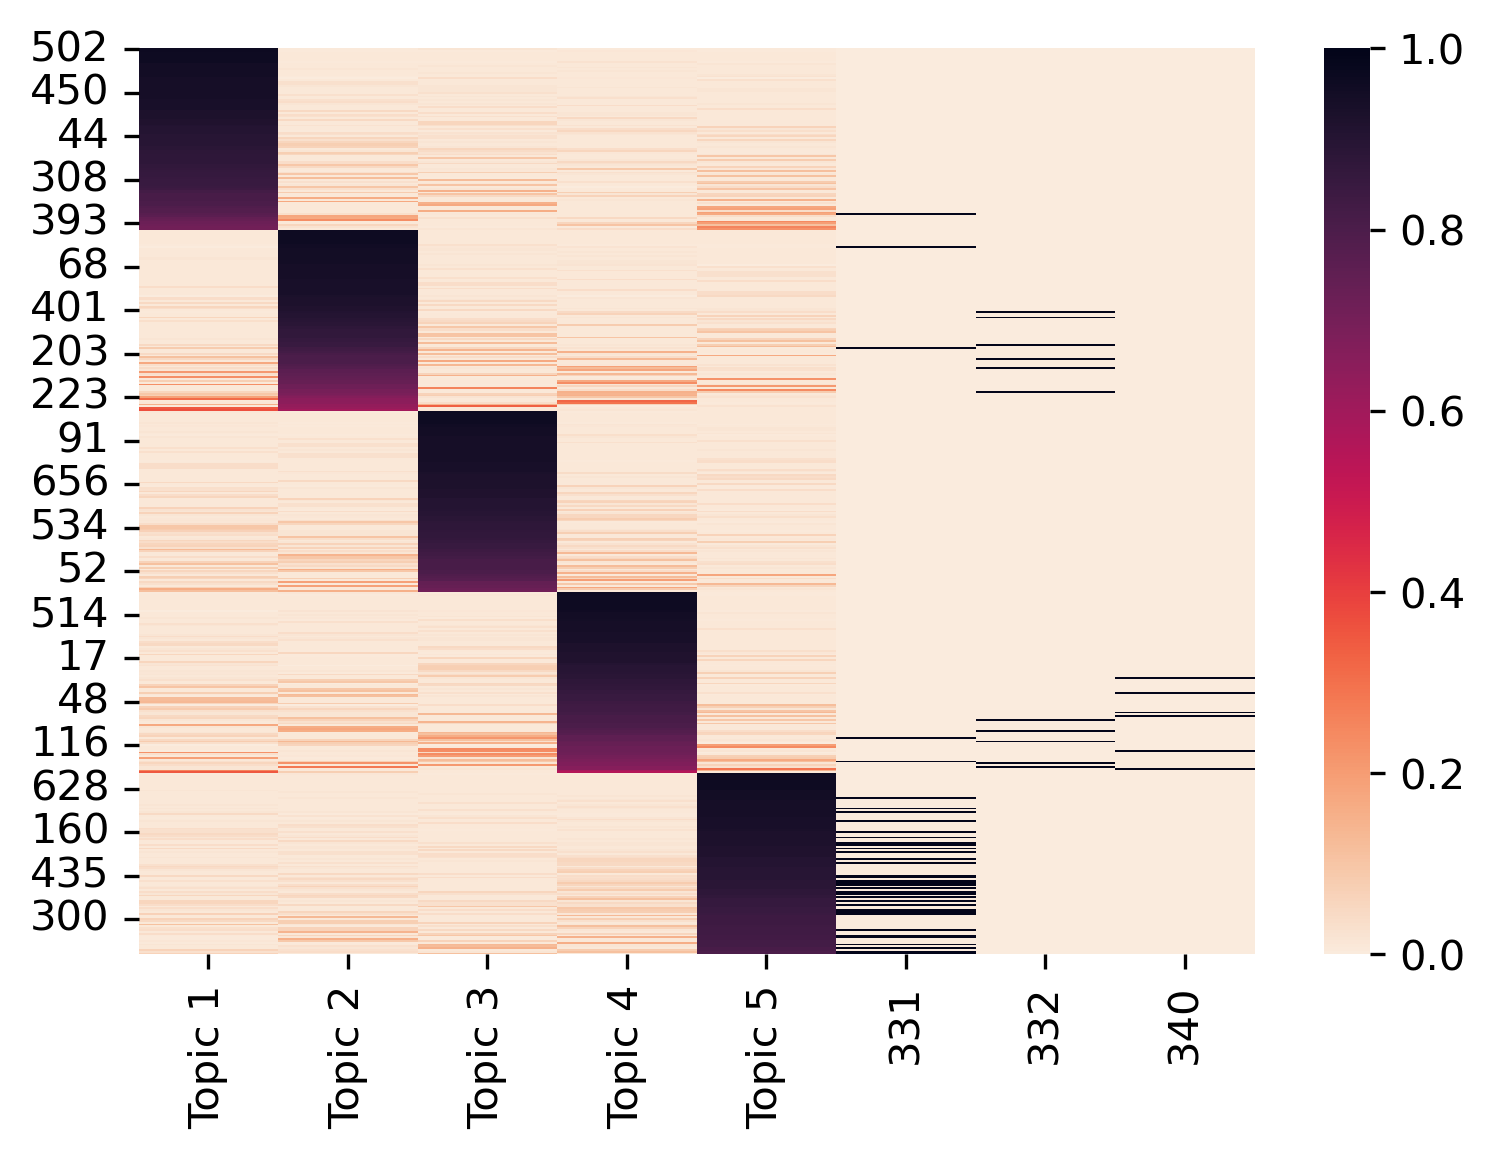

In [12]:
theta_df = pd.DataFrame(theta_r, columns=["Topic 1", "Topic 2", "Topic 3", "Topic 4", "Topic 5"])
theta_df = pd.concat([theta_df, cood_topic_df], axis=1)
top_0_theta = theta_df.nlargest(100, "Topic 1")
top_1_theta = theta_df.nlargest(100, "Topic 2")
top_2_theta = theta_df.nlargest(100, "Topic 3")
top_3_theta = theta_df.nlargest(100, "Topic 4")
top_4_theta = theta_df.nlargest(100, "Topic 5")

top_theta_df = pd.DataFrame()

top_theta_df =  pd.concat([top_0_theta, top_1_theta])
top_theta_df =  pd.concat([top_theta_df, top_2_theta])
top_theta_df =  pd.concat([top_theta_df, top_3_theta])
top_theta_df =  pd.concat([top_theta_df, top_4_theta])

plt.figure(dpi=300)
ax = seaborn.heatmap(top_theta_df, cmap="rocket_r")
plt.show()